In [ ]:
!pip install music21

In [ ]:
pip install matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pip install pretty_midi

In [ ]:
!pip install MIDIUtil

#MIDIにする行列の設定は上のセル
from midiutil import MIDIFile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for MIDIUtil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54568 sha256=8c5c83114fef992bafbe1acae2d8d01ade327f835ebaae49f46e6fd02824014d
  Stored in directory: /root/.cache/pip/wheels/af/43/4a/00b5e4f2fe5e2cd6e92b461995a3a97a2cebb30ab5783501b0
Successfully built MIDIUtil


### xmlファイルを0,1の二値行列に変換する関数

In [ ]:
from music21 import converter
import numpy as np

score = converter.parse("/content/drive/MyDrive/music21/Tchaikovsky_Op._71a_-_The_Nutcracker_Suite_for_String_Quartet_-_I._Ouverture_Miniature.mxl")

#128,64版の行列化
def musicxml_to_binary_matrix_128_64(score):

      # バイナリ行列を格納するためのリスト
      binary_matrices = []

      #出力用のリスト
      matrix_list=[]

      #出力の時にpartの番号がわかるようにするため
      part_count=1

      # 各パートについて処理
      for part in score.parts:

          # このパートの音符と和音の開始時間と終了時間を記録するためのリストを初期化
          note_events = []

          #パートごとに楽譜の階層構造を平坦化し、音符や和音などの全要素に順番にアクセス、elementとは<music21.note.Note C#>など
          for element in part.flatten():

              #現在処理中の要素（element）が単一の音符（Note）であるかどうかを判断
              if 'Note' in element.classes:
                  #element.offsetは楽譜の時間をバイナリ行列の列のインデックスにマッピングするためのスケール係数（スケーリング係数）として機能する
                  #element.offset のデフォルト単位は、四分音符、つまりある音符が、楽譜の最初から四分音符いくつ目の時間にあたる場所かをデフォルトで表す、そのためそれに４をかけたら16分音符いくつ目かになる
                  #elementは四分音符単位の区切り
                  #試しに0.25にしたら4分音符の４倍の長さの単位になるので小節数が分かった
                  #4にした場合、曲が4分音符いくつ分かを表す
                  start_time = int(element.offset * 4)  # 四分音符の単位で時間を計算

                  #音符の持続時間を計算
                  #element.duration.quarterLengthは、音符がどのくらい長く鳴るかを四分音符単位で表したもの
                  duration = int(element.duration.quarterLength * 4)  # 四分音符の単位で持続時間を計算

                  midi_number = element.pitch.midi  # MIDIノート番号
                  note_events.append((start_time, duration, midi_number))#開始時間、持続時間、MIDIノート番号をタプルとしてnote_eventsリストに追加
              elif 'Chord' in element.classes:  # 和音の処理
                  start_time = int(element.offset * 4)
                  duration = int(element.duration.quarterLength * 1)
                  for note in element.pitches:
                      midi_number = note.midi
                      note_events.append((start_time, duration, midi_number))
                                                                                 #print(note_events)
          # 最大時間を計算
          max_time = max(start_time + duration for start_time, duration, _ in note_events)
          #print(max_time)

          # バイナリ行列を作成（128行、最大時間の列）
          matrix = np.zeros((128, max_time), dtype=int)
          #print(matrix.shape)

          # 音符イベントを行列に反映
          for start_time, duration, midi_number in note_events:
              matrix[midi_number, start_time:start_time + duration] = 1  #note_eventsで音の高さ、開始時間、継続時間がわかっているので、行列の(音の高さ,開始時間から開始時間+継続時間のスライス)で音が鳴っている時間に1を代入している

          # このパートのバイナリ行列をリストに追加
          #matrix_list.append(matrix)
          binary_matrices.append(matrix)#binary_matricesはmatrixがpartの個数回付け足されているリスト、1つ目のリストは1つ目のパートの行列

          #パートごとに分かれた行列を4小節ごとに区切ってパートごとのリストにする
          split_arrays=[]

          for r in range(len(binary_matrices)):
                #binary_matricesのr番目の全ての行とi列目からi+15列目までをsplit_arraysに格納する、0から16ごとにbinary_matricesのr番目の列数までiは変化する
                #これをパートの個数回繰り返した結果がsplt_arrays
               split_arrays.append([binary_matrices[r][:, i:i+64] for i in range(0, binary_matrices[r].shape[1], 64)])

       #return split_arrays
      return split_arrays   #入力の確認をする際にはコメントアウトを解除

#musicxml_to_binary_matrix(score)
#musicxml_to_binary_matrix(score)[1][0][0]  #関数結果の2番目には2パートの行列があるのでそれの最初の部分
len(musicxml_to_binary_matrix_128_64(score)[0])

23

### 行列をMIDIファイルに変換する関数

In [ ]:

def midi (matrix):
      # MIDIファイルを初期化
      midi_file = MIDIFile(1)  # トラック数1
      track = 0   # トラック0
      time = 0    # 開始時間
      midi_file.addTrackName(track, time, "Track")
      midi_file.addTempo(track, time, 60)  # テンポ120 BPM

      # 行列からMIDIノートを生成
      for row in range(matrix.shape[0]):
          note = row  # MIDIノートナンバー
          duration = 0  # 音符の持続時間
          for col in range(matrix.shape[1]):
              if matrix[row, col] == 1:
                  duration += 1  # 音符の持続時間を延長

              elif duration > 0:
                  # 音符の終わりに到達
                  midi_file.addNote(track, 0, note, time + col - duration, duration, 100)
                  duration = 0

          #行の要素の全てが1の場合、行の最後でもfor文の中のifブロックが実行されるのでelifが実行されず保存がないためforループの外で行の全てが1の場合を保存
          if duration > 0:
              print("activated")
              midi_file.addNote(track, 0, note, time + matrix.shape[1] - duration, duration, 100) #forループ外なのでcolではなくmatrix.shape[1]-1


      # MIDIファイルを保存
      with open("output.mid", "wb") as output_file:
          midi_file.writeFile(output_file)
      return output_file

### xmlファイルを行列化する関数を用いて、全曲を行列化しリストに格納

In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Wedding_March_from_Midsummer_Nigts_Dream_F.Mendelssohn"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Wedding_March_p1=score_array[0][1:9]   #[4:36]と同じ　　[:38]
Wedding_March_p2=score_array[1][1:9]   #[:38]
print(len(Wedding_March_p1))
print(len(Wedding_March_p2))


8
8


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Wedding_March_for_string_quarter."
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Wedding_March_quartet_1=score_array[0][1:9]    #[1:38]    #ここで長さを揃える
Wedding_March_quartet_2=score_array[1][1:9]    #[1:38]
Wedding_March_quartet_3=score_array[2][1:9]    #[1:38]
Wedding_March_quartet_4=score_array[3][1:9]    #[1:38]

print(len(Wedding_March_quartet_1[:730]))
print(len(Wedding_March_quartet_2))
print(len(Wedding_March_quartet_3))
print(len(Wedding_March_quartet_4))

8
8
8
8


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="The_Entertainer_-_Scott_Joplin"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
The_entertainer_p1=score_array[0][1:11]      #[4:44]
The_entertainer_p2=score_array[1][1:11]      #[4:44]
print(len(The_entertainer_p1))
print(len(The_entertainer_p2))

10
10


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="The_Entertainer_for_String_Quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

The_entertainer_quartet_1=score_array[0][1:11]        #[1:45]    #ここで長さを揃える
The_entertainer_quartet_2=score_array[1][1:11]        #[1:45]
The_entertainer_quartet_3=score_array[2][1:11]        #[1:45]
The_entertainer_quartet_4=score_array[3][1:11]        #[1:45]

print(len(The_entertainer_quartet_1[:730]))
print(len(The_entertainer_quartet_2))
print(len(The_entertainer_quartet_3))
print(len(The_entertainer_quartet_4))

10
10
10
10


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Sarabande_Suite_in_D_minor_HWV_437"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Sarabande_p1=score_array[0][:12]       #[:49]
Sarabande_p2=score_array[1][:12]       #[:49]
print(len(Sarabande_p1))
print(len(Sarabande_p2))



12
12


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="sarabande_quartet_Haendel"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Sarabande_quartet_1=score_array[0][:12]       #[:49]    #ここで長さを揃える
Sarabande_quartet_2=score_array[1][:12]       #[:49]
Sarabande_quartet_3=score_array[2][:12]       #[:49]
Sarabande_quartet_4=score_array[3][:12]       #[:49]

print(len(Sarabande_quartet_1[:730]))
print(len(Sarabande_quartet_2))
print(len(Sarabande_quartet_3))
print(len(Sarabande_quartet_4))

12
12
12
12


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Nearer_My_God_To_Thee_Piano_arrangement"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Nearer_my_god_to_three_p1=score_array[0][:15]       #[:63]
Nearer_my_god_to_three_p2=score_array[1][:15]       #[:63]
print(len(Nearer_my_god_to_three_p1))
print(len(Nearer_my_god_to_three_p2))

15
15


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Nearer_my_God_to_Thee"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Nearer_my_god_to_three_quartet_1=score_array[0][:15]       #[:63]    #ここで長さを揃える
Nearer_my_god_to_three_quartet_2=score_array[1][:15]       #[:63]
Nearer_my_god_to_three_quartet_3=score_array[2][:15]       #[:63]
Nearer_my_god_to_three_quartet_4=score_array[3][:15]       #[:63]

print(len(Nearer_my_god_to_three_quartet_1[:730]))
print(len(Nearer_my_god_to_three_quartet_2))
print(len(Nearer_my_god_to_three_quartet_3))
print(len(Nearer_my_god_to_three_quartet_4))

15
15
15
15


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Eine_Kleine_Nachtmusik"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Eine_Kleine_Nachtmusik_p1=score_array[0][:34]   #[:136]
Eine_Kleine_Nachtmusik_p2=score_array[1][:34]   #[:136]
print(len(Eine_Kleine_Nachtmusik_p1))
print(len(Eine_Kleine_Nachtmusik_p2))

34
34


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Serenade_No._13_in_G_Eine_Kleine_Nachtmusik_K525"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)



Eine_Kleine_Nachtmusik_quartet_1=score_array[0][:34]   #[:136]    #ここで長さを揃える
Eine_Kleine_Nachtmusik_quartet_2=score_array[1][:34]   #[:136]
Eine_Kleine_Nachtmusik_quartet_3=score_array[2][:34]   #[:136]
Eine_Kleine_Nachtmusik_quartet_4=score_array[3][:34]   #[:136]

print(len(Eine_Kleine_Nachtmusik_quartet_1[:730]))
print(len(Eine_Kleine_Nachtmusik_quartet_2))
print(len(Eine_Kleine_Nachtmusik_quartet_3))
print(len(Eine_Kleine_Nachtmusik_quartet_4))

34
34
34
34


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Mozart_-_Lacrimosa_from_the_Requiem_in_D_minor"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Lacrimosa_p1=score_array[0][:-1]#ピアノ譜の最終小節の長さが短いのでカット
Lacrimosa_p2=score_array[1][:-1]
print(len(Lacrimosa_p1))
print(len(Lacrimosa_p2))

10
10


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Mozart_Lacrimosa_string_quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Lacrimosa_quartet_1=score_array[0][:-2]    #ここで長さを揃える
Lacrimosa_quartet_2=score_array[1][:-2]
Lacrimosa_quartet_3=score_array[2][:-2]
Lacrimosa_quartet_4=score_array[3][:-2]

print(len(Lacrimosa_quartet_1[:730]))
print(len(Lacrimosa_quartet_2))
print(len(Lacrimosa_quartet_3))
print(len(Lacrimosa_quartet_4))

10
10
10
10


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Dance_of_the_Sugar_Plum_Fairy-Tchaikovsky_ease"    #この部分をlacrimosaにした場合は音符が正しく表示されたのでsugar plum fairyの問題
score = converter.parse("/content/drive/MyDrive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Dance_of_the_sugar_plum_fairy_p1=score_array[0][:5]   #[:20]
Dance_of_the_sugar_plum_fairy_p2=score_array[1][:5]   #[:20]#最後の小節がp2だけ短いのでカット
print(len(Dance_of_the_sugar_plum_fairy_p1))
print(len(Dance_of_the_sugar_plum_fairy_p2))

5
5


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Dance_of_the_Sugar_Plum_Fairy_Nutcracker_Suite_-_Pyotr_Ilyich_Tchaikovsky"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Dance_of_the_sugar_plum_fairy_quartet_1=score_array[0][:5]   #[:20]    #ここで長さを揃える
Dance_of_the_sugar_plum_fairy_quartet_2=score_array[1][:5]   #[:20]
Dance_of_the_sugar_plum_fairy_quartet_3=score_array[2][:5]   #[:20]
Dance_of_the_sugar_plum_fairy_quartet_4=score_array[3][:5]   #[:20]

print(len(Dance_of_the_sugar_plum_fairy_quartet_1[:730]))
print(len(Dance_of_the_sugar_plum_fairy_quartet_2))
print(len(Dance_of_the_sugar_plum_fairy_quartet_3))
print(len(Dance_of_the_sugar_plum_fairy_quartet_4))

5
5
5
5


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Morning_Mood"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Morning_mood_p1=score_array[0][:4]     #[0:15]  #[15]から微妙に異なるため
Morning_mood_p2=score_array[1][:4]     #[0:15]
print(len(Morning_mood_p1))
print(len(Morning_mood_p2))


4
4


In [ ]:
''' midi(Morning_mood_quartet_1[0])
from google.colab import files
files.download('output.mid')   #ピッタリあっている '''

" midi(Morning_mood_quartet_1[0])\nfrom google.colab import files\nfiles.download('output.mid')   #ピッタリあっている "

In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Edvard_Grieg_Peer_Gynt_Suite_No._1_Morning_Mood"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Morning_mood_quartet_1=score_array[0][:4]     #[:15]
Morning_mood_quartet_2=score_array[1][:4]     #[:15]
Morning_mood_quartet_3=score_array[2][:4]     #[:15]
Morning_mood_quartet_4=score_array[3][:4]     #[:15]

print(len(Morning_mood_quartet_1))
print(len(Morning_mood_quartet_2))
print(len(Morning_mood_quartet_3))
print(len(Morning_mood_quartet_4))

4
4
4
4


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


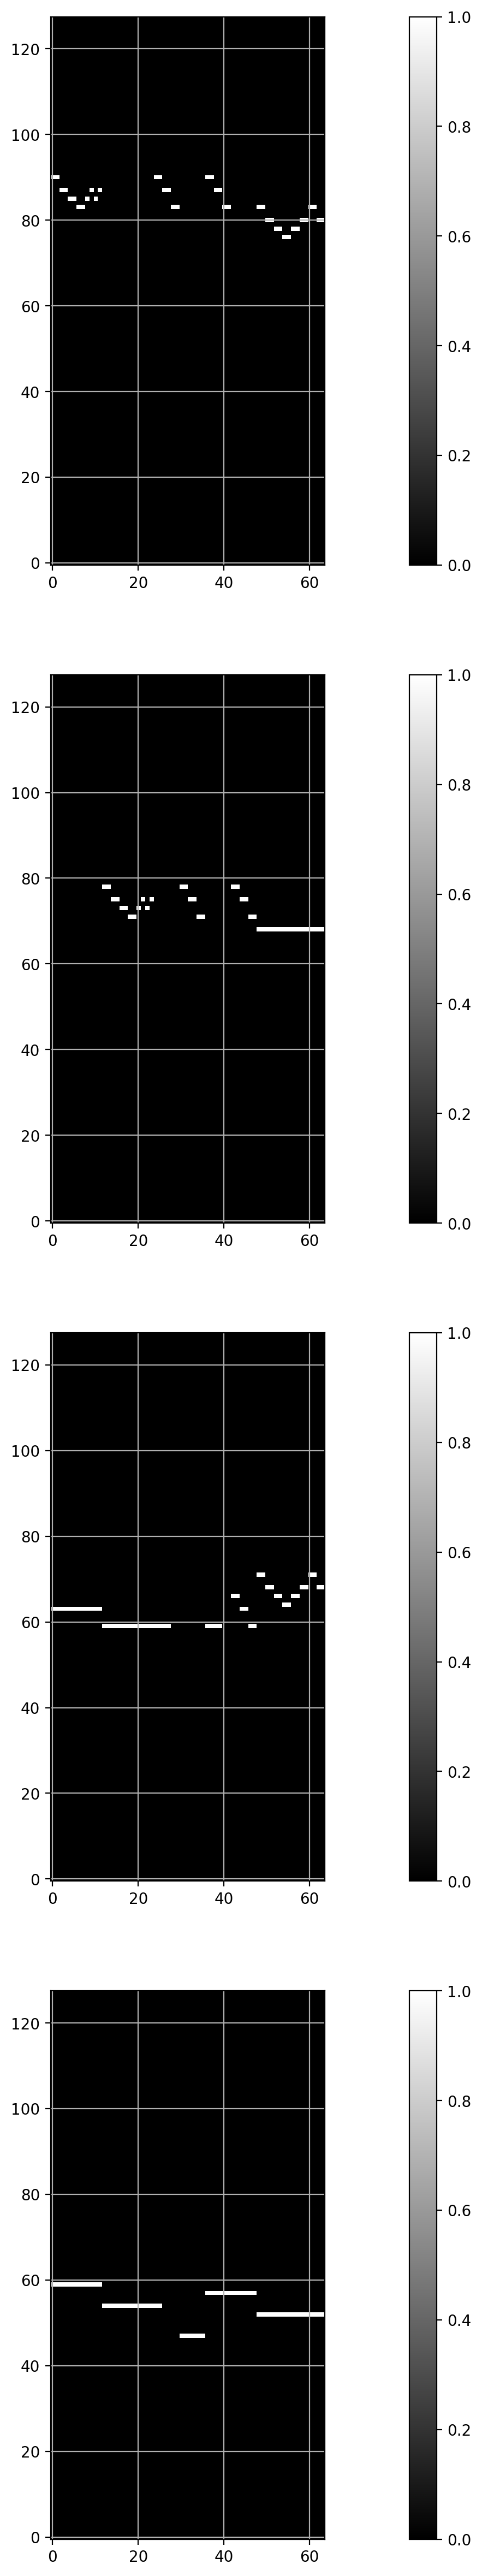

In [ ]:
plt.figure(figsize=(20,30))
data_0=musicxml_to_binary_matrix_128_64(score)[0][3]  #右手最初の4分音符４つ分    [1][0]で2パート目の最初
data_1=musicxml_to_binary_matrix_128_64(score)[1][3]
data_2=musicxml_to_binary_matrix_128_64(score)[2][3]
data_3=musicxml_to_binary_matrix_128_64(score)[3][3]    #左手最初の4分音符4つ分
print(data_0)

plt.subplot(4,1,1)#2行１列のサブプロットのうちの１つ目
plt.imshow(data_0,cmap='gray',interpolation='none')
plt.colorbar()
plt.gca().invert_yaxis()
plt.grid(True)

plt.subplot(4,1,2)#2行１列のサブプロットのうちの2つ目
plt.imshow(data_1,cmap='gray',interpolation='none')
plt.colorbar()
plt.gca().invert_yaxis()
plt.grid(True)

plt.subplot(4,1,3)#2行１列のサブプロットのうちの2つ目
plt.imshow(data_2,cmap='gray',interpolation='none')
plt.colorbar()
plt.gca().invert_yaxis()
plt.grid(True)

plt.subplot(4,1,4)#2行１列のサブプロットのうちの2つ目
plt.imshow(data_3,cmap='gray',interpolation='none')
plt.colorbar()
plt.gca().invert_yaxis()
plt.grid(True)



plt.show()

In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Tetris_theme_Korobeiniki"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Korobeiniki_tetris_p1=score_array[0][0:2]+score_array[0][4:7]   #[0:8]+score_array[0][16:31]
Korobeiniki_tetris_p2=score_array[1][0:2]+score_array[1][4:7]
print(len(Korobeiniki_tetris_p1))
print(len(Korobeiniki_tetris_p2))


5
5


In [ ]:
''' midi(Korobeiniki_tetris_quartet_1[4])
from google.colab import files
files.download('output.mid')    '''

" midi(Korobeiniki_tetris_quartet_1[4])\nfrom google.colab import files\nfiles.download('output.mid')    "

In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Korobeiniki_Tetris_A_Theme"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Korobeiniki_tetris_quartet_1=score_array[0][0:4]+score_array[0][6:7]   #[0:16] +score_array[0][24:31]    #最後の小節の行列の長さが違うので[:32]
Korobeiniki_tetris_quartet_2=score_array[1][0:4]+score_array[0][6:7]   #[0:16] +score_array[1][24:31]
Korobeiniki_tetris_quartet_3=score_array[2][0:4]+score_array[0][6:7]   #[0:16] +score_array[2][24:31]
Korobeiniki_tetris_quartet_4=score_array[3][0:4]+score_array[0][6:7]   #[0:16] +score_array[3][24:31]

print(len(Korobeiniki_tetris_quartet_1[:730]))
print(len(Korobeiniki_tetris_quartet_2))
print(len(Korobeiniki_tetris_quartet_3))
print(len(Korobeiniki_tetris_quartet_4))

5
5
5
5


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Ludwig_Van_Beethoven_-_Ode_To_Joy_-_Piano_Arranged"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Ode_to_joy_p1=score_array[0][:10]      #[:42]
Ode_to_joy_p2=score_array[1][:10]      #[:42]
print(len(Ode_to_joy_p1))
print(len(Ode_to_joy_p2))


10
10


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Ode_to_Joy_Quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Ode_to_joy_quartet_1=score_array[0][:10]      #[:42]    #ここで長さを揃える
Ode_to_joy_quartet_2=score_array[1][:10]      #[:42]
Ode_to_joy_quartet_3=score_array[2][:10]      #[:42]
Ode_to_joy_quartet_4=score_array[3][:10]      #[:42]

print(len(Ode_to_joy_quartet_1[:730]))
print(len(Ode_to_joy_quartet_2))
print(len(Ode_to_joy_quartet_3))
print(len(Ode_to_joy_quartet_4))

10
10
10
10


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Beethoven_Virus"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Beethovenvirus_p1=score_array[0][:29]     #[:136]
Beethovenvirus_p2=score_array[1][:29]     #[:136]
print(len(Beethovenvirus_p1))
print(len(Beethovenvirus_p2))


29
29


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Beethoven_Virus (1)"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Beethovenvirus_quartet_1=score_array[0][:29]     #[:136]    #ここで長さを揃える
Beethovenvirus_quartet_2=score_array[1][:29]     #[:136]
Beethovenvirus_quartet_3=score_array[2][:29]     #[:136]
Beethovenvirus_quartet_4=score_array[3][:29]     #[:136]

print(len(Beethovenvirus_quartet_1[:730]))
print(len(Beethovenvirus_quartet_2))
print(len(Beethovenvirus_quartet_3))
print(len(Beethovenvirus_quartet_4))

29
29
29
29


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Canon_in_D (1)"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするか
Canon_p1=score_array[0][:22]     #[:89]
Canon_p2=score_array[1][:22]     #[:89]
print(len(Canon_p1))
print(len(Canon_p2))


22
22


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Canon_in_D"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Canon_quartet_1=score_array[0][:22]     #[:89]    #ここで長さを揃える
Canon_quartet_2=score_array[1][:22]     #[:89]
Canon_quartet_3=score_array[2][:22]     #[:89]
Canon_quartet_4=score_array[3][:22]     #[:89]

print(len(Canon_quartet_1[:730]))
print(len(Canon_quartet_2))
print(len(Canon_quartet_3))
print(len(Canon_quartet_4))

22
22
22
22


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Stndchen_Serenade"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Serenade_p1=score_array[0][:6]    #[:27]
Serenade_p2=score_array[1][:6]    #[:27]
print(len(Serenade_p1))
print(len(Serenade_p2))


6
6


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Serenade_by_Schubert_for_String_Quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Serenade_quartet_1=score_array[0][:6]    #[:27]    #ここで長さを揃える
Serenade_quartet_2=score_array[1][:6]    #[:27]
Serenade_quartet_3=score_array[2][:6]    #[:27]
Serenade_quartet_4=score_array[3][:6]    #[:27]

print(len(Serenade_quartet_1[:730]))
print(len(Serenade_quartet_2))
print(len(Serenade_quartet_3))
print(len(Serenade_quartet_4))

6
6
6
6


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Elgar_-__Enigma_Variations_-_XI._Nimrod"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Nimrod_p1=score_array[0][1:7]    #[:31] #ピアノ譜の最後小節の長さ違うので最後から2小節目まで
Nimrod_p2=score_array[1][1:7]    #[:31]
print(len(Nimrod_p1))
print(len(Nimrod_p2))


6
6


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Nimrod_for_string_quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Nimrod_quartet_1=score_array[0][1:7]    #[1:32]    #ここで長さを揃える
Nimrod_quartet_2=score_array[1][1:7]    #[1:32]
Nimrod_quartet_3=score_array[2][1:7]    #[1:32]
Nimrod_quartet_4=score_array[3][1:7]    #[1:32]

print(len(Nimrod_quartet_1[:730]))
print(len(Nimrod_quartet_2))
print(len(Nimrod_quartet_3))
print(len(Nimrod_quartet_4))

6
6
6
6


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Jupiter_I_vow_to_thee_my_county"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Jupiter_p1=score_array[0][:4]    #[:17]#18番目が長さが(128,16)ではないので17番目まで
Jupiter_p2=score_array[1][:4]    #[:17]
print(len(Jupiter_p1))
print(len(Jupiter_p2))


4
4


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Jupiter__Fuld_version"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Jupiter_quartet_1=score_array[0][:4]    #[:17]   #ここで長さを揃える
Jupiter_quartet_2=score_array[1][:4]    #[:17]
Jupiter_quartet_3=score_array[2][:4]    #[:17]
Jupiter_quartet_4=score_array[3][:4]    #[:17]

print(len(Jupiter_quartet_1[:730]))
print(len(Jupiter_quartet_2))
print(len(Jupiter_quartet_3))
print(len(Jupiter_quartet_4))

4
4
4
4


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Beethoven_Symphony_No._7_2nd_movement_Piano_solo"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#吹奏楽譜の最後の二小節がないのでピアノ譜と同じ長さに揃える(2/4なので１つ削除)
Beethoven_Symphony_p1=score_array[0][:29]    #[:138]
Beethoven_Symphony_p2=score_array[1][:29]    #[:138]
print(len(Beethoven_Symphony_p1))
print(len(Beethoven_Symphony_p2))

29
29


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Beethoven_Symphony_No_7_2nd_Movement"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Beethoven_Symphony_quartet_1=score_array[0][:29]    #[:138]    #ここで長さを揃える
Beethoven_Symphony_quartet_2=score_array[1][:29]    #[:138]
Beethoven_Symphony_quartet_3=score_array[2][:29]    #[:138]
Beethoven_Symphony_quartet_4=score_array[3][:29]    #[:138]

print(len(Beethoven_Symphony_quartet_1))
print(len(Beethoven_Symphony_quartet_2))
print(len(Beethoven_Symphony_quartet_3))
print(len(Beethoven_Symphony_quartet_4))

29
29
29
29


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Air_on_the_G_String_-_Bach_Piano_Solo"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#最後の小節の長さが違うので最後１小節カット
Air_on_the_G_String_p1=score_array[0][:4]     #[:18]
Air_on_the_G_String_p2=score_array[1][:4]     #[:18]
print(len(Air_on_the_G_String_p1))
print(len(Air_on_the_G_String_p2))

4
4


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Air_on_the_G_string_cuarteto_de_cuerdas"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Air_on_the_G_String_quartet_1=score_array[0][:4]     #[:18]    #ここで長さを揃える
Air_on_the_G_String_quartet_2=score_array[1][:4]     #[:18]
Air_on_the_G_String_quartet_3=score_array[2][:4]     #[:18]
Air_on_the_G_String_quartet_4=score_array[3][:4]     #[:18]

print(len(Air_on_the_G_String_quartet_1))
print(len(Air_on_the_G_String_quartet_2))
print(len(Air_on_the_G_String_quartet_3))
print(len(Air_on_the_G_String_quartet_4))

4
4
4
4


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Opus_18_No.4_Arr._For_Piano"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#最後の小節の長さが違うので最後１小節カット
Opus_18_p1=score_array[0][:54]    #[:219]
Opus_18_p2=score_array[1][:54]    #[:219]
print(len(Opus_18_p1))
print(len(Opus_18_p2))

/usr/local/lib/python3.10/dist-packages/music21/musicxml/xmlToM21.py:5312: MusicXMLWarning: Could not import octave-shift: Error in getting Ottava
  warnings.warn(f'Could not import {tag}: {excep}', MusicXMLWarning)
/usr/local/lib/python3.10/dist-packages/music21/musicxml/xmlToM21.py:5312: MusicXMLWarning: Could not import wedge: Error in getting DynamicWedges
  warnings.warn(f'Could not import {tag}: {excep}', MusicXMLWarning)


54
54


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="String_Quartet_No._4_in_C_minor_Opus_18_No._4.mscz"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Opus_18_quartet_1=score_array[0][:54]    #[:219]    #ここで長さを揃える
Opus_18_quartet_2=score_array[1][:54]    #[:219]
Opus_18_quartet_3=score_array[2][:54]    #[:219]
Opus_18_quartet_4=score_array[3][:54]    #[:219]

print(len(Opus_18_quartet_1))
print(len(Opus_18_quartet_2))
print(len(Opus_18_quartet_3))
print(len(Opus_18_quartet_4))

54
54
54
54


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Nutcrcaker_Overture"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#2つ違うだけだが行列を確認した結果、2/4の最後2小節をカット
Nutcrcaker_Overture_p1=score_array[0][:22]   #[:90]
Nutcrcaker_Overture_p2=score_array[1][:22]   #[:90]
print(len(Nutcrcaker_Overture_p1))
print(len(Nutcrcaker_Overture_p2))

22
22


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Tchaikovsky_Op._71a_-_The_Nutcracker_Suite_for_String_Quartet_-_I._Ouverture_Miniature"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Nutcrcaker_Overture_quartet_1=score_array[0][:22]   #[:90]    #ここで長さを揃える
Nutcrcaker_Overture_quartet_2=score_array[1][:22]   #[:90]
Nutcrcaker_Overture_quartet_3=score_array[2][:22]   #[:90]
Nutcrcaker_Overture_quartet_4=score_array[3][:22]   #[:90]

print(len(Nutcrcaker_Overture_quartet_1))
print(len(Nutcrcaker_Overture_quartet_2))
print(len(Nutcrcaker_Overture_quartet_3))
print(len(Nutcrcaker_Overture_quartet_4))

22
22
22
22


In [ ]:
''' #scorearrayを128,16ずつの行列のを保存して長さを調整すれば揃うが2セットなのでデータセットに用いない
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Hungarian_Dance_No_5_in_G_Minor"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#ピアノ譜2/4の1〜16小節目と四重奏譜3〜18が同じ
#ピアノ33〜48と四重奏譜19〜34が同じ

Hungarian_Dance_p1=score_array[0][4:6]        #[:7]+(score_array[0][16:24])
Hungarian_Dance_p2=score_array[1][:1]+(score_array[0][4:6])        #[:7]+(score_array[1][16:24])
print(len(Hungarian_Dance_p1))
print(len(Hungarian_Dance_p2)) '''

' #scorearrayを128,16ずつの行列のを保存して長さを調整すれば揃うが2セットなのでデータセットに用いない\n#ピアノ譜格納版\n#split_arraysには2つ行列がある\nscore_name="Hungarian_Dance_No_5_in_G_Minor"\nscore = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")   \nscore_array=musicxml_to_binary_matrix_128_64(score)\n\n#ピアノ譜2/4の1〜16小節目と四重奏譜3〜18が同じ   \n#ピアノ33〜48と四重奏譜19〜34が同じ\n\nHungarian_Dance_p1=score_array[0][4:6]        #[:7]+(score_array[0][16:24])\nHungarian_Dance_p2=score_array[1][:1]+(score_array[0][4:6])        #[:7]+(score_array[1][16:24])\nprint(len(Hungarian_Dance_p1))\nprint(len(Hungarian_Dance_p2)) '

In [ ]:
''' #四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Hungarian_Dance_no._5_for_string_quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Hungarian_Dance_quartet_1=score_array[0][1:2]       # [2:9]+(score_array[0][9:17])
Hungarian_Dance_quartet_2=score_array[0][1:2]+(score_array[0][3:4])     #[2:9]+(score_array[0][9:17])
Hungarian_Dance_quartet_3=score_array[0][1:2]+(score_array[0][3:4])     #[2:9]+(score_array[0][9:17])
Hungarian_Dance_quartet_4=score_array[0][1:2]+(score_array[0][3:4])     #[2:9]+(score_array[0][9:17])

print(len(Hungarian_Dance_quartet_1))
print(len(Hungarian_Dance_quartet_2))
print(len(Hungarian_Dance_quartet_3))
print(len(Hungarian_Dance_quartet_4)) '''

' #四重奏譜格納版\n#score_arraysには4つ行列がある\nscore_name="Hungarian_Dance_no._5_for_string_quartet"\nscore = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")\nscore_array=musicxml_to_binary_matrix_128_64(score)\n\nHungarian_Dance_quartet_1=score_array[0][1:2]       # [2:9]+(score_array[0][9:17])\nHungarian_Dance_quartet_2=score_array[0][1:2]+(score_array[0][3:4])     #[2:9]+(score_array[0][9:17])\nHungarian_Dance_quartet_3=score_array[0][1:2]+(score_array[0][3:4])     #[2:9]+(score_array[0][9:17])\nHungarian_Dance_quartet_4=score_array[0][1:2]+(score_array[0][3:4])     #[2:9]+(score_array[0][9:17])\n\nprint(len(Hungarian_Dance_quartet_1))\nprint(len(Hungarian_Dance_quartet_2))\nprint(len(Hungarian_Dance_quartet_3))\nprint(len(Hungarian_Dance_quartet_4)) '

In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="The_Glorious_State_Anthem_of_the_Soviet_Union"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Anthem_of_the_Soviet_Union_p1=score_array[0][:5]    #[:21]
Anthem_of_the_Soviet_Union_p2=score_array[1][:5]    #[:21]
print(len(Anthem_of_the_Soviet_Union_p1))
print(len(Anthem_of_the_Soviet_Union_p2))

5
5


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="National_Anthem_of_the_Soviet_UnionRussia_for_string_quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Anthem_of_the_Soviet_Union_quartet_1=score_array[0][:5]    #[:21]    #ここで長さを揃える
Anthem_of_the_Soviet_Union_quartet_2=score_array[1][:5]    #[:21]
Anthem_of_the_Soviet_Union_quartet_3=score_array[2][:5]    #[:21]
Anthem_of_the_Soviet_Union_quartet_4=score_array[3][:5]    #[:21]

print(len(Anthem_of_the_Soviet_Union_quartet_1))
print(len(Anthem_of_the_Soviet_Union_quartet_2))
print(len(Anthem_of_the_Soviet_Union_quartet_3))
print(len(Anthem_of_the_Soviet_Union_quartet_4))

5
5
5
5


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Beethoven_-_Sonata_No._14_Op._27_No._2_MondscheinMoonlight"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
Moonlight_p1=score_array[0][:28]  #[:113]
Moonlight_p2=score_array[1][:28]  #[:113]
print(len(Moonlight_p1))
print(len(Moonlight_p2))

28
28


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Moonlight_Sonata_Arr._for_String_Quartet"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

Moonlight_quartet_1=score_array[0][:28]  #[:113]    #ここで長さを揃える
Moonlight_quartet_2=score_array[1][:28]  #[:113]
Moonlight_quartet_3=score_array[2][:28]  #[:113]
Moonlight_quartet_4=score_array[3][:28]  #[:113]

print(len(Moonlight_quartet_1))
print(len(Moonlight_quartet_2))
print(len(Moonlight_quartet_3))
print(len(Moonlight_quartet_4))

28
28
28
28


In [ ]:
#ピアノ譜格納版
#split_arraysには2つ行列がある
score_name="Le_Cygne_The_Swan"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

#出力の数字は実際の小節数と異なるのは途中で3/4になったり2/4になったりするから
The_Swan_p1=score_array[0][:9]    #[:39]
The_Swan_p2=score_array[1][:9]    #[:39]
print(len(The_Swan_p1))
print(len(The_Swan_p2))

9
9


In [ ]:
#四重奏譜格納版
#score_arraysには4つ行列がある
score_name="Le_Cygne_The_Swan_-_Saint-Sans"
score = converter.parse("/content/drive/My Drive/music21/"+score_name+".mxl")
score_array=musicxml_to_binary_matrix_128_64(score)

The_Swan_quartet_1=score_array[0][:9]    #[:39]    # パート４の最後の小節が足りてないので[:39]]
The_Swan_quartet_2=score_array[1][:9]    #[:39]
The_Swan_quartet_3=score_array[2][:9]    #[:39]
The_Swan_quartet_4=score_array[3][:9]    #[:39]

print(len(The_Swan_quartet_1))
print(len(The_Swan_quartet_2))
print(len(The_Swan_quartet_3))
print(len(The_Swan_quartet_4))

9
9
9
9


In [ ]:
#HungarianDanceを含まない
piano_list_128_64=Wedding_March_p1+Wedding_March_p2+The_entertainer_p1+The_entertainer_p2+Sarabande_p1+Sarabande_p2+Nearer_my_god_to_three_p1+Nearer_my_god_to_three_p2+Eine_Kleine_Nachtmusik_p1+Eine_Kleine_Nachtmusik_p2+Lacrimosa_p1+Lacrimosa_p2+Dance_of_the_sugar_plum_fairy_p1+Dance_of_the_sugar_plum_fairy_p2+Morning_mood_p1+Morning_mood_p2+Korobeiniki_tetris_p1+Korobeiniki_tetris_p2+Ode_to_joy_p1+Ode_to_joy_p2+Beethovenvirus_p1+Beethovenvirus_p2+Canon_p1+Canon_p2+Serenade_p1+Serenade_p2+Nimrod_p1+Nimrod_p2+Jupiter_p1+Jupiter_p2+Beethoven_Symphony_p1+Beethoven_Symphony_p2+Air_on_the_G_String_p1+Air_on_the_G_String_p2+Opus_18_p1+Opus_18_p2+Nutcrcaker_Overture_p1+Nutcrcaker_Overture_p2+Anthem_of_the_Soviet_Union_p1+Anthem_of_the_Soviet_Union_p2+Moonlight_p1+Moonlight_p2+The_Swan_p1+The_Swan_p2
print(len(piano_list_128_64))
print(piano_list_128_64[0].shape)

662
(128, 64)


In [ ]:
quartet_list_128_64=Wedding_March_quartet_1+Wedding_March_quartet_2+Wedding_March_quartet_3+Wedding_March_quartet_4+The_entertainer_quartet_1+The_entertainer_quartet_2+The_entertainer_quartet_3+The_entertainer_quartet_4+Sarabande_quartet_1+Sarabande_quartet_2+Sarabande_quartet_3+Sarabande_quartet_4+Nearer_my_god_to_three_quartet_1+Nearer_my_god_to_three_quartet_2+Nearer_my_god_to_three_quartet_3+Nearer_my_god_to_three_quartet_4+Eine_Kleine_Nachtmusik_quartet_1+Eine_Kleine_Nachtmusik_quartet_2+Eine_Kleine_Nachtmusik_quartet_3+Eine_Kleine_Nachtmusik_quartet_4+Lacrimosa_quartet_1+Lacrimosa_quartet_2+Lacrimosa_quartet_3+Lacrimosa_quartet_4+Dance_of_the_sugar_plum_fairy_quartet_1+Dance_of_the_sugar_plum_fairy_quartet_2+Dance_of_the_sugar_plum_fairy_quartet_3+Dance_of_the_sugar_plum_fairy_quartet_4+Morning_mood_quartet_1+Morning_mood_quartet_2+Morning_mood_quartet_3+Morning_mood_quartet_4+Korobeiniki_tetris_quartet_1+Korobeiniki_tetris_quartet_2+Korobeiniki_tetris_quartet_3+Korobeiniki_tetris_quartet_4+Ode_to_joy_quartet_1+Ode_to_joy_quartet_2+Ode_to_joy_quartet_3+Ode_to_joy_quartet_4+Beethovenvirus_quartet_1+Beethovenvirus_quartet_2+Beethovenvirus_quartet_3+Beethovenvirus_quartet_4+Canon_quartet_1+Canon_quartet_2+Canon_quartet_3+Canon_quartet_4+Serenade_quartet_1+Serenade_quartet_2+Serenade_quartet_3+Serenade_quartet_4+Nimrod_quartet_1+Nimrod_quartet_2+Nimrod_quartet_3+Nimrod_quartet_4+Jupiter_quartet_1+Jupiter_quartet_2+Jupiter_quartet_3+Jupiter_quartet_4+Beethoven_Symphony_quartet_1+Beethoven_Symphony_quartet_2+Beethoven_Symphony_quartet_3+Beethoven_Symphony_quartet_4+Air_on_the_G_String_quartet_1+Air_on_the_G_String_quartet_2+Air_on_the_G_String_quartet_3+Air_on_the_G_String_quartet_4+Opus_18_quartet_1+Opus_18_quartet_2+Opus_18_quartet_3+Opus_18_quartet_4+Nutcrcaker_Overture_quartet_1+Nutcrcaker_Overture_quartet_2+Nutcrcaker_Overture_quartet_3+Nutcrcaker_Overture_quartet_4+Anthem_of_the_Soviet_Union_quartet_1+Anthem_of_the_Soviet_Union_quartet_2+Anthem_of_the_Soviet_Union_quartet_3+Anthem_of_the_Soviet_Union_quartet_4+Moonlight_quartet_1+Moonlight_quartet_2+Moonlight_quartet_3+Moonlight_quartet_4+The_Swan_quartet_1+The_Swan_quartet_2+The_Swan_quartet_3+The_Swan_quartet_4
print(len(quartet_list_128_64))
print(quartet_list_128_64[0].shape)

1324
(128, 64)


### ピアノ行列と四重奏行列が格納されたリストをnpyファイルとして保存

In [ ]:
np.save('/content/drive/MyDrive/music21/data/piano_list_128_64',piano_list_128_64)
np.save('/content/drive/MyDrive/music21/data/quartet_list_128_64',quartet_list_128_64)

In [ ]:
piano_list_128_64=np.load('/content/drive/MyDrive/music21/data/piano_list_128_64.npy')  #inputs_checkはi=10の時の入力とラベル
quartet_list_128_64=np.load('/content/drive/MyDrive/music21/data/quartet_list_128_64.npy')


(128, 64)


In [ ]:
#np.loadからの読み込み確認
print(len(piano_list_128_64))
print(len(quartet_list_128_64))
print(piano_list_128_64[0].shape)
print(quartet_list_128_64[0].shape)

662
1324
(128, 64)
(128, 64)
